In [1]:
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary

# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns

In [2]:
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
train_path = 'train'
label_list = [
    'men',
    'women',
    ]

for i, label in enumerate(label_list):
    img_path = os.path.join(train_path, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label, "class_id":i}, index=[1])
        df = pd.concat([df, new_data], ignore_index=True)

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)

In [3]:
df.head()

,path,label,class_id
0,train/men/63.jpg,men,0
1,train/men/77.jpg,men,0
2,train/men/88.jpg,men,0
3,train/men/89.jpg,men,0
4,train/men/76.jpg,men,0


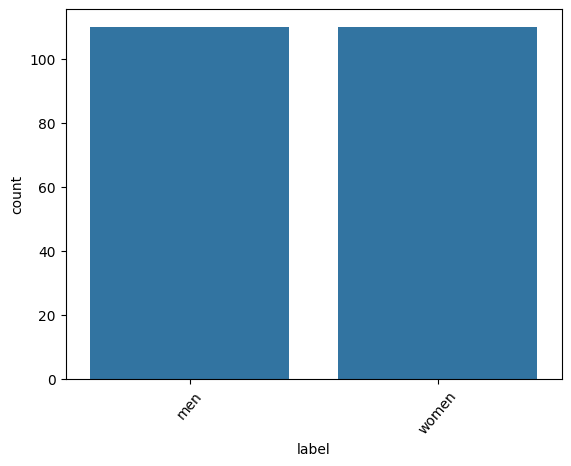

In [4]:
sns.countplot(x = df["label"])
plt.xticks(rotation = 50);

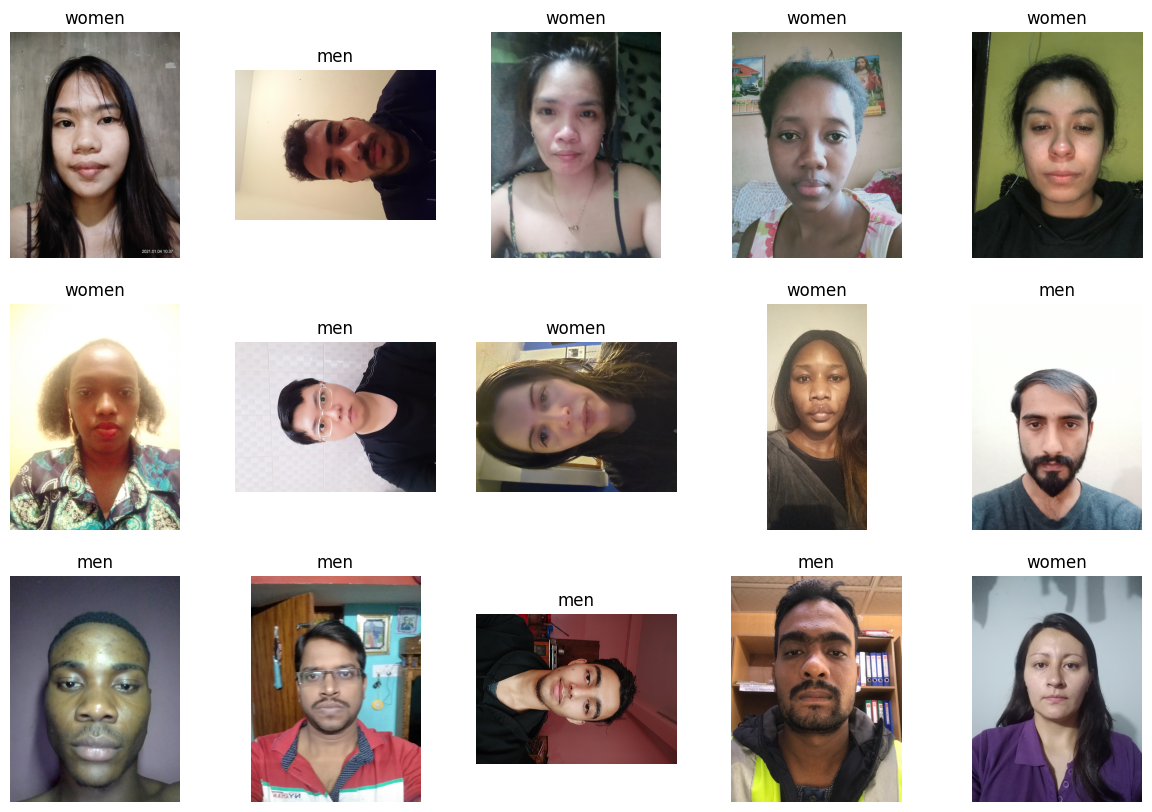

In [5]:
show_imgs = 15
idx = np.random.randint(0, len(df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [6]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [8]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook
train_df, val_df = train_test_split(df, test_size=0.2,random_state=9898)
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [9]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:176
val data:44


In [10]:
# class_size = len(df['label'].unique())
class_size = len(label_list)
model = models.efficientnet_v2_s(weights='DEFAULT')
model.classifier[1] = torch.nn.Linear(1280, class_size)

# model = models.swin_v2_s(weights='DEFAULT')
# model.head = nn.Linear(in_features=model.head.in_features, out_features=class_size)
model(torch.randn((16,3,224,224))).shape

torch.Size([16, 2])

In [11]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0 
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        
        # First we'll clean the cache of optimizer
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(data_)
        
        # Computing loss 
        loss = loss_fn(outputs,target_)
        loss.backward()
        
        # Optimizing model
        optimizer.step()
        
        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0 
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)
            
            # Computing loss 
            loss = loss_fn(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")

criterion  = nn.CrossEntropyLoss()


# Optimizer which will use gradients to train model.
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1

# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')
    
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "checkpoints/last.pth")

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.6963, train_acc: 0.523     val_loss: 0.6893, val_acc: 0.477     Learning Rate: 0.0001


  2%|▏         | 1/50 [03:49<3:07:32, 229.65s/it]

EPOCH: 1     train_loss: 0.6179, train_acc: 0.688     val_loss: 0.5672, val_acc: 0.682     Learning Rate: 0.0001


  4%|▍         | 2/50 [08:26<3:25:42, 257.14s/it]

EPOCH: 2     train_loss: 0.5344, train_acc: 0.761     val_loss: 0.4775, val_acc: 0.773     Learning Rate: 0.0001


  6%|▌         | 3/50 [12:35<3:18:49, 253.83s/it]

EPOCH: 3     train_loss: 0.4559, train_acc: 0.812     val_loss: 0.3080, val_acc: 0.864     Learning Rate: 0.0001


  8%|▊         | 4/50 [17:51<3:33:25, 278.39s/it]

EPOCH: 4     train_loss: 0.3575, train_acc: 0.864     val_loss: 0.2663, val_acc: 0.864     Learning Rate: 0.0001


 10%|█         | 5/50 [22:02<3:21:13, 268.30s/it]

EPOCH: 5     train_loss: 0.3080, train_acc: 0.864     val_loss: 0.2762, val_acc: 0.864     Learning Rate: 0.0001


 12%|█▏        | 6/50 [26:55<3:22:58, 276.78s/it]

EPOCH: 6     train_loss: 0.2265, train_acc: 0.932     val_loss: 0.3170, val_acc: 0.818     Learning Rate: 1e-05


 14%|█▍        | 7/50 [30:55<3:09:42, 264.72s/it]

EPOCH: 7     train_loss: 0.2084, train_acc: 0.932     val_loss: 0.2580, val_acc: 0.864     Learning Rate: 1e-05


 16%|█▌        | 8/50 [34:09<2:49:30, 242.15s/it]

EPOCH: 8     train_loss: 0.2006, train_acc: 0.938     val_loss: 0.2510, val_acc: 0.864     Learning Rate: 1e-05


 18%|█▊        | 9/50 [37:28<2:36:15, 228.68s/it]

EPOCH: 9     train_loss: 0.1882, train_acc: 0.926     val_loss: 0.2552, val_acc: 0.886     Learning Rate: 1e-05


 20%|██        | 10/50 [40:53<2:27:40, 221.51s/it]

EPOCH: 10     train_loss: 0.3376, train_acc: 0.852     val_loss: 0.2321, val_acc: 0.886     Learning Rate: 1e-05


 22%|██▏       | 11/50 [44:54<2:27:45, 227.33s/it]

EPOCH: 11     train_loss: 0.2519, train_acc: 0.886     val_loss: 0.2162, val_acc: 0.886     Learning Rate: 1e-05


 24%|██▍       | 12/50 [49:15<2:30:25, 237.53s/it]

EPOCH: 12     train_loss: 0.2205, train_acc: 0.915     val_loss: 0.2080, val_acc: 0.886     Learning Rate: 1e-05


 26%|██▌       | 13/50 [53:44<2:32:28, 247.25s/it]

EPOCH: 13     train_loss: 0.2043, train_acc: 0.926     val_loss: 0.2036, val_acc: 0.886     Learning Rate: 1.0000000000000002e-06


 28%|██▊       | 14/50 [58:55<2:39:50, 266.42s/it]

EPOCH: 14     train_loss: 0.1967, train_acc: 0.943     val_loss: 0.2060, val_acc: 0.864     Learning Rate: 1.0000000000000002e-06


 30%|███       | 15/50 [1:02:23<2:25:10, 248.87s/it]

EPOCH: 15     train_loss: 0.2381, train_acc: 0.915     val_loss: 0.2003, val_acc: 0.864     Learning Rate: 1.0000000000000002e-06


 32%|███▏      | 16/50 [1:05:37<2:11:41, 232.40s/it]

EPOCH: 16     train_loss: 0.2160, train_acc: 0.909     val_loss: 0.2003, val_acc: 0.886     Learning Rate: 1.0000000000000002e-06


 34%|███▍      | 17/50 [1:08:50<2:01:16, 220.49s/it]

EPOCH: 17     train_loss: 0.2059, train_acc: 0.915     val_loss: 0.1884, val_acc: 0.909     Learning Rate: 1.0000000000000002e-06


 36%|███▌      | 18/50 [1:12:04<1:53:21, 212.56s/it]

EPOCH: 18     train_loss: 0.2056, train_acc: 0.898     val_loss: 0.2109, val_acc: 0.864     Learning Rate: 1.0000000000000002e-06


 38%|███▊      | 19/50 [1:15:13<1:46:03, 205.27s/it]

EPOCH: 19     train_loss: 0.1670, train_acc: 0.920     val_loss: 0.2239, val_acc: 0.864     Learning Rate: 1.0000000000000002e-06


 40%|████      | 20/50 [1:18:25<1:40:44, 201.49s/it]

EPOCH: 20     train_loss: 0.1665, train_acc: 0.949     val_loss: 0.1880, val_acc: 0.886     Learning Rate: 1.0000000000000002e-07


 42%|████▏     | 21/50 [1:22:06<1:40:10, 207.25s/it]

EPOCH: 21     train_loss: 0.2305, train_acc: 0.898     val_loss: 0.1980, val_acc: 0.864     Learning Rate: 1.0000000000000002e-07


 44%|████▍     | 22/50 [1:25:35<1:36:58, 207.79s/it]

EPOCH: 22     train_loss: 0.2347, train_acc: 0.920     val_loss: 0.1998, val_acc: 0.909     Learning Rate: 1.0000000000000002e-07


 46%|████▌     | 23/50 [1:29:07<1:34:01, 208.96s/it]

EPOCH: 23     train_loss: 0.2503, train_acc: 0.903     val_loss: 0.2276, val_acc: 0.864     Learning Rate: 1.0000000000000002e-07


 48%|████▊     | 24/50 [1:32:19<1:28:20, 203.87s/it]

EPOCH: 24     train_loss: 0.1872, train_acc: 0.932     val_loss: 0.2260, val_acc: 0.864     Learning Rate: 1.0000000000000002e-07


 50%|█████     | 25/50 [1:35:44<1:25:08, 204.35s/it]

EPOCH: 25     train_loss: 0.2521, train_acc: 0.892     val_loss: 0.2291, val_acc: 0.864     Learning Rate: 1.0000000000000002e-07


 50%|█████     | 25/50 [1:39:47<1:39:47, 239.52s/it]

Earlystop!


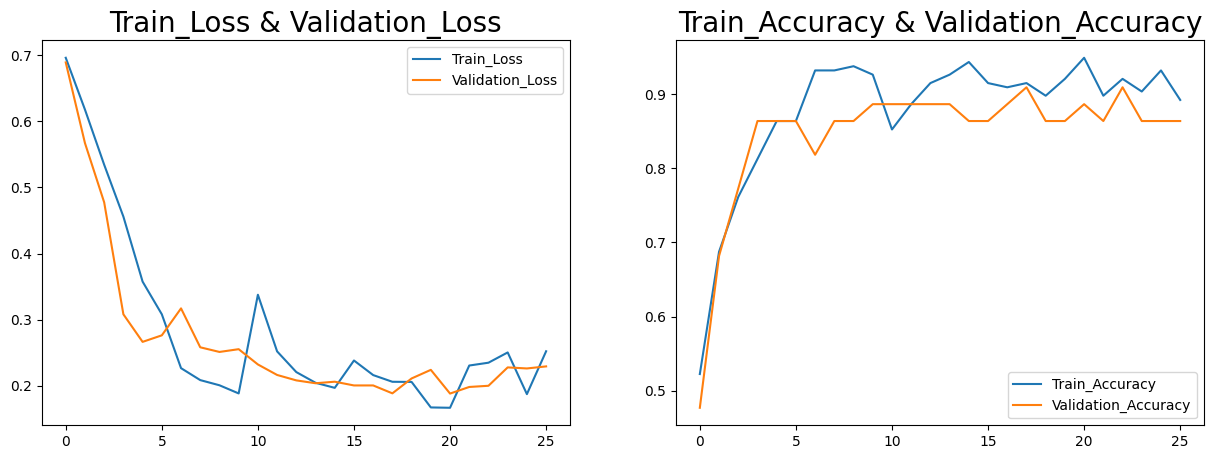

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [14]:
test_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
test_path = 'test'
label_list = [
    'men',
    'women',
    ]

for i, label in enumerate(label_list):
    img_path = os.path.join(test_path, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label, "class_id":i}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)
test_df[["class_id"]] = test_df[["class_id"]].astype(int)

test_dataset = MyDataset(val_df, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
model.load_state_dict(torch.load('checkpoints/best.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for (data_,target_) in tqdm(test_loader):
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        outputs = model(data_)
        _,pred = torch.max(outputs,dim=1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)


100%|██████████| 3/3 [00:21<00:00,  7.32s/it]


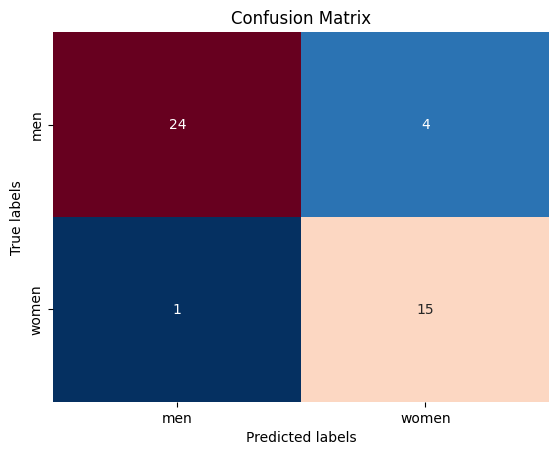

In [16]:
ax= plt.subplot()
CM = confusion_matrix(y_true,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False,cmap='RdBu_r',
            xticklabels= label_list, yticklabels=label_list)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

In [17]:
clf_report = classification_report(y_true, y_pred, target_names = label_list)
print(clf_report)

              precision    recall  f1-score   support

         men       0.96      0.86      0.91        28
       women       0.79      0.94      0.86        16

    accuracy                           0.89        44
   macro avg       0.87      0.90      0.88        44
weighted avg       0.90      0.89      0.89        44

